In [2]:
import torch
import torch.nn as nn
from machine_layout import MachineTemplate, BackgroundTemplate, BoundaryError
import numpy as np
import random
import time
import copy
from tqdm import trange

import matplotlib as plt
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader
from collections import namedtuple, deque

d:\ProgramData\Anaconda3\envs\torch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


In [4]:
class fac_model(nn.Module):
    #input_size is 2*machine(as factory in and out)
    #output is 2*machine
    def __init__(self, input_size, output_size):
        super(fac_model, self).__init__()
        self.fc1 = nn.Linear(input_size, 32)
        self.fc2 = nn.Linear(32, 128)
        self.fc3 = nn.Linear(128, 512)
        # self.fc4 = nn.Linear(512, 8)
        # self.fc5 = nn.Linear(128, 256)
        # self.fc6 = nn.Linear(256, 512)
        # self.fc7 = nn.Linear(512, 1024)
        # self.fc8 = nn.Linear(1024, 512)
        self.fc9 = nn.Linear(512, output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.relu(x)
        # x = self.fc4(x)
        # x = self.relu(x)
        # x = self.fc5(x)
        # x = self.relu(x)
        # x = self.fc6(x)
        # x = self.relu(x)
        # x = self.fc7(x)
        # x = self.relu(x)
        # x = self.fc8(x)
        # x = self.relu(x)
        x = self.fc9(x)
        x = self.relu(x)
        x*=100
        return x.int()

In [5]:

m1 = np.ones([20, 10])
m2 = np.ones([10, 20])
m3 = np.ones([30, 20])
m4 = np.ones([10, 30])

machine1 = MachineTemplate(m1, 'm1', inandoutpos = [[10,0],[20,10]])
machine2 = MachineTemplate(m2, 'm2', inandoutpos = [[10,0],[0,15]])
machine3 = MachineTemplate(m3, 'm3', inandoutpos = [[20,0],[20,20]])
machine4 = MachineTemplate(m4, 'm4', inandoutpos = [[0,20],[10,30]])

ICN = BackgroundTemplate(np.zeros([100, 100]))
ICN.machine_add(machine1)
ICN.machine_add(machine2)
ICN.machine_add(machine3)
ICN.machine_add(machine4)

ICN.product_line("p1", ['m1', 'm2', 'm3', 'm4'])
ICN.product_line("p2", ['m1', 'm2', 'm3'])
ICN.product_line("p3", ['m2', 'm3'])
ICN.product_line("p4", ['m3', 'm4', 'm1'])
machines = ['m1', 'm2', 'm3', 'm4']
h, w = ICN.bg.shape

In [6]:
def factory_random_batch(ICN:BackgroundTemplate):
    random.seed(time.time())
    ICN.reset_bg()
    batch_state = []
    for m_code in machines:
        while True:
            randh = random.randint(0, h-10)
            randw = random.randint(0, w-10)
            try:
                ICN.machine_batch([randh, randw], m_code)
                batch_state.append([randh, randw])
                break
            except BoundaryError as e:
                continue
    return np.array(batch_state).flatten()
    

In [7]:
def factory_batch_loss(ICN: BackgroundTemplate, batch_state, collide_mul = 8):
    ICN.reset_bg()
    machines = ['m1', 'm2', 'm3', 'm4']
    h, w = 100, 100
    for idx, m_code in enumerate(machines):
        try:
            ICN.machine_batch(batch_state[idx*2:idx*2+2], m_code)
        except BoundaryError as e:
            return torch.from_numpy(np.array(1e4))
    return torch.from_numpy(np.array(ICN.loss(collide_mul=8)))

In [8]:
model = fac_model(2*len(ICN.machine_dict), 2*len(ICN.machine_dict))
optimizer = torch.optim.SGD(model.parameters(), lr = 1)

In [17]:
nb_epochs = int(1e4)
best_loss = int(1e5)
best_model = None
batch_size = int(1e2)
for epoch in (pbar := trange(nb_epochs)):
    for batch_idx in range(batch_size):
        batch = factory_random_batch(ICN)
        # prediction = model(torch.tensor(batch).float().to(device))
        cost = factory_batch_loss(ICN, batch, collide_mul = 2)

        # cost로 H(x) 계산
        # optimizer.zero_grad()
        # cost.requires_grad_(True)
        # cost.backward()
        # optimizer.step()
        # if epoch % 10 == 0 and batch_idx %(batch_size//5) == 0:
        #     print('Epoch {:4d}/{} Batch {}/{} Cost: {:.6f}'.format(
        #         epoch, nb_epochs, batch_idx, batch_size, cost))
        if best_loss > ICN.loss():
            best_loss = copy.deepcopy(ICN.loss())
            pbar.set_description(str(best_loss))
            best_fac = copy.deepcopy(ICN)
            best_model = copy.deepcopy(model)
            best_batch = copy.deepcopy(batch)

431.6718133911268: 100%|██████████| 10000/10000 [06:29<00:00, 25.68it/s]


100000.0
[43 23 35 36 16 56 54 62]


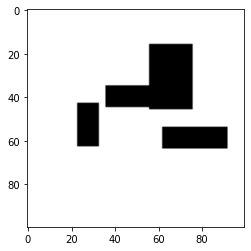

In [16]:
best_fac.bg2img()
print(best_loss)
print(best_batch)

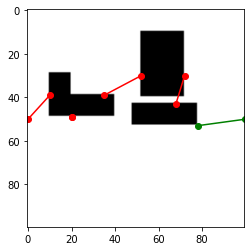

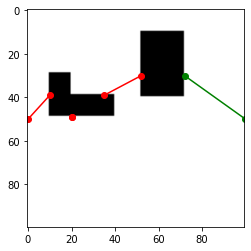

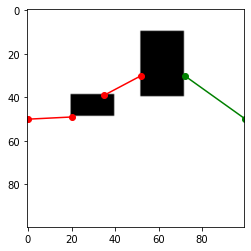

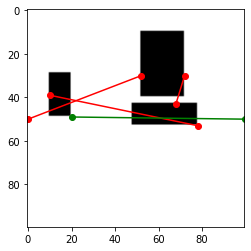

In [ ]:
best_fac.product_line_img("p1")
best_fac.product_line_img("p2")
best_fac.product_line_img("p3")
best_fac.product_line_img("p4")

In [ ]:
print(prediction)

tensor([ 81, 184,   0, 364,   0,   0,   0,   0], dtype=torch.int32)


In [ ]:
for i in model.parameters():
    print(i)

Parameter containing:
tensor([[-2.8592e-01, -2.3029e-02,  3.2747e-01,  2.1977e-01,  2.3991e-01,
          1.6989e-01, -1.1231e-02,  1.7784e-01],
        [-1.7262e-01,  2.0238e-01,  2.3981e-01,  8.5188e-02, -2.5507e-01,
          1.2871e-01,  5.0552e-02, -2.7881e-02],
        [ 5.2085e-02, -2.8857e-01, -1.3118e-01,  1.1822e-01, -2.2076e-01,
          9.8493e-02, -2.2526e-02, -1.6751e-01],
        [-2.9503e-01, -3.0396e-03, -2.1712e-01, -8.6279e-02, -3.4532e-01,
         -7.3284e-03,  2.0452e-01,  3.4094e-01],
        [-6.1000e-02, -3.2857e-01, -2.5551e-01,  3.0200e-01, -2.9722e-01,
          1.7334e-01, -4.6302e-02, -2.3211e-01],
        [ 2.0594e-01, -6.3314e-02,  3.2413e-02,  5.1124e-02,  8.9040e-02,
         -3.5071e-01, -2.0450e-01,  1.3760e-01],
        [ 1.4996e-01,  2.9727e-01, -3.1367e-01,  3.0361e-01,  2.5307e-01,
          2.1585e-01,  1.5196e-01,  1.5905e-01],
        [-6.7327e-02, -3.2954e-01, -2.3878e-01,  2.2193e-01, -1.1675e-01,
          4.5380e-02, -2.4389e-01,  5.4372e

In [ ]:
#parameters들이 적게 나와서 생기는 문제인것 같다(int값 유의) 그냥 h랑 w를 곱해버리면 어떨까?